# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
xkeys_plt = [  # input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False
do_nonstat_correct = True

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 10/03/2023 17:35:39: assembling batch analysis settings...
 10/03/2023 17:35:39: pv main analysis notebook started on 2023-03-10 at 17:35:39


### Input summary table figure

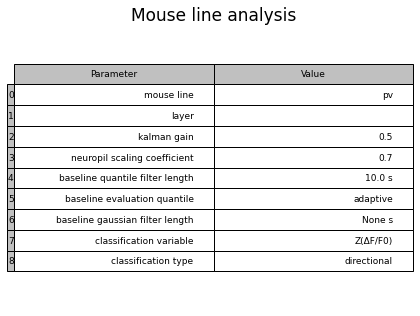

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats)

 10/03/2023 17:35:40: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv:
 10/03/2023 17:35:40: loading mouse-region data from 20190606_mouse2_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190606_mouse2_region2.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190629_mouse2_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190630_mouse3_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190702_mouse1_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190702_mouse5_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190703_mouse4_region1.h5
 10/03/2023 17:35:40: loading mouse-region data from 20190821_mouse3_region1.h5
 10/03/2023 17:35:41: loading mouse-region data from 20190821_mouse6_region1.h5
 10/03/2023 17:35:41: loading mouse-region d

run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190606_mouse2_region1,109,nan,nan,110,110,110,110,109,109,109,108,109,nan,nan,nan
20190606_mouse2_region2,122,nan,nan,122,122,122,122,122,122,122,122,122,nan,nan,nan
20190629_mouse2_region1,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
20190630_mouse3_region1,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
20190702_mouse1_region1,169,169,169,169,169,169,169,169,169,169,169,165,169,169,169
20190702_mouse5_region1,102,102,102,102,102,102,101,102,100,102,102,102,102,102,102
20190703_mouse4_region1,82,82,82,82,82,82,82,82,82,81,82,82,82,81,82


### Load exclusion table

In [7]:
exclude_table = get_exclude_table(line=mouseline)
exclude_table

,poor segmentation,potential dead cells,large variation in fluorescence baseline,no/weak response,abnormal response amplitudes,abnormal drop 50-60% DC,abnormal drop 0.4-0.6 MPa
dataset,,,,,,,
20190606_mouse2_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190606_mouse2_region2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190629_mouse2_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190630_mouse3_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190702_mouse1_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190702_mouse5_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190703_mouse4_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190821_mouse3_region1,NaN,NaN,y,NaN,NaN,NaN,NaN
20190821_mouse6_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspect cell maps and exclude outlier datasets 

 10/03/2023 17:35:44: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 16.84it/s]

 10/03/2023 17:35:45: empty exclude list -> ignoring


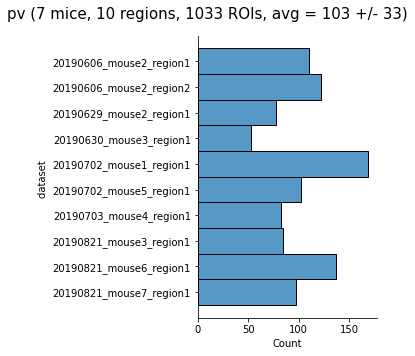

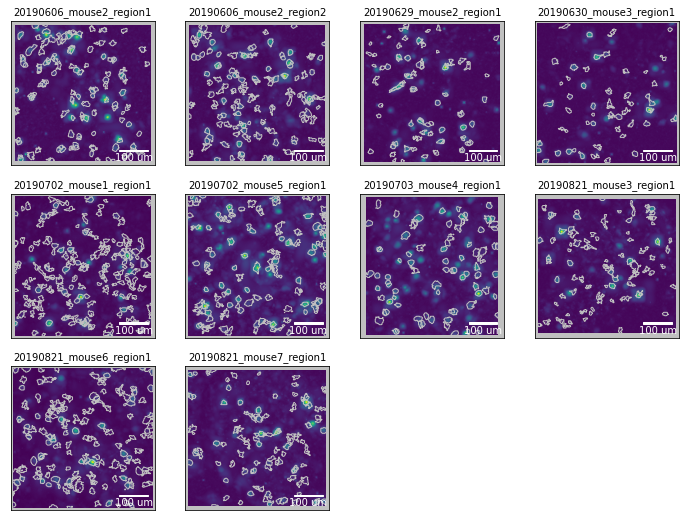

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)
seg_exclude = get_exclude_list(exclude_table, [Label.POORSEG, Label.DEADCELLS])
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue=None, 
    outliers=seg_exclude)
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=seg_exclude)

### Inspect baseline variation throughout experiments

 10/03/2023 17:35:46: inspecting variations in baseline fluorescence across experiments...


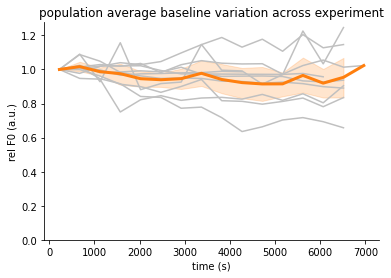

In [9]:
relF0_key = f'rel {Label.F0}'
from constants import MAX_F0_REL_VAR

def get_rel_F0(data, aggbyrun=True):
    ''' Extract temporal evolution of F0 '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    runid_map = trialagg_stats.loc[dataset_id, Label.RUNID].groupby(Label.RUN).first()
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    data[Label.TIME] = get_index_along_experiment(data.index, runid_map=runid_map) / fps
    # If specified, aggregate by run
    data = data.groupby(Label.RUN).median()
    # Compute relative variation
    i0 = data[Label.TIME].idxmin()
    y0 = data.loc[i0, Label.F0]
    data[relF0_key] = data[Label.F0] / y0
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Plot time evolution of average baseline along experiment, for each dataset
logger.info('inspecting variations in baseline fluorescence across experiments...')
figs['popavg F0 across experiment'], ax = plt.subplots(figsize=(6, 4))
sns.despine(ax=ax)
ax.set_title(f'population average baseline variation across experiment')
popagg_F0_per_run = popagg_timeseries.groupby(Label.DATASET).apply(get_rel_F0)
pltkwargs = dict(
    data=popagg_F0_per_run,
    x=Label.TIME, 
    y=relF0_key,
    ax=ax,
)
sns.lineplot(
    ci=None, 
    hue=Label.DATASET,
    palette=get_uniform_palette(popagg_F0_per_run),
    legend=False,
    **pltkwargs
)
sns.lineplot(
    lw=3,
    color=Palette.LINE[mouseline],
    **pltkwargs
)
ax.set_ylim(0, ax.get_ylim()[1])
if ax.get_legend() is not None:
    sns.move_legend(
        ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False, 
        ncol=int(np.ceil(len(popagg_F0_per_run.index.unique(Label.DATASET)) / 15))
    )

# # Identify datasets with outlier variations in baseline fluorescence
# rel_F0_bounds = (1 - MAX_F0_REL_VAR, 1 + MAX_F0_REL_VAR)
# ax.axhspan(*rel_F0_bounds, fc='silver', ec='k', alpha=0.3)
# relF0_outlier_runs = ~is_within(popagg_F0_per_run[relF0_key], rel_F0_bounds)
# noutlier_runs = relF0_outlier_runs.groupby(Label.DATASET).sum()
# relF0_outliers = noutlier_runs[noutlier_runs > 0].index.values.tolist()
# noutliers = len(relF0_outliers)
# if noutliers > 0:
#     relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
#     logger.warning(f'identified {noutliers} datasets with baseline fluorescence variations outside {rel_F0_bounds}:\n{relF0_outliers_str}')
#     trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
#         trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=relF0_outliers)

### Inspect run presentation order per dataset and potential consequences on evoked activity

 10/03/2023 17:35:46: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 10/03/2023 17:35:46: run ID not part of (P (MPa), DC (%)) -> no filtering
 10/03/2023 17:35:46: sub-indexing data...
 10/03/2023 17:35:46: filtering data...
 10/03/2023 17:35:46: cross-checking filters...
 10/03/2023 17:35:46: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 10/03/2023 17:35:46: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 10/03/2023 17:35:46: run ID not part of (P (MPa), DC (%)) -> no filtering
 10/03/2023 17:35:46: sub-indexing data...
 10/03/2023 17:35:46: filtering data...
 10/03/2023 17:35:46: cross-checking filters...
 10/03/2023 17:35:46: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 10/03/2023 17:35:46: parameter sequences across datasets:


dataset,20190606_mouse2_region1,20190606_mouse2_region2,20190629_mouse2_region1,20190630_mouse3_region1,20190702_mouse1_region1,20190702_mouse5_region1,20190703_mouse4_region1,20190821_mouse3_region1,20190821_mouse6_region1,20190821_mouse7_region1
run ID,,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_30%DC,0.80MPa_40%DC,NaN,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_40%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,NaN,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.80MPa_60%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,NaN,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC,0.80MPa_70%DC,0.20MPa_50%DC


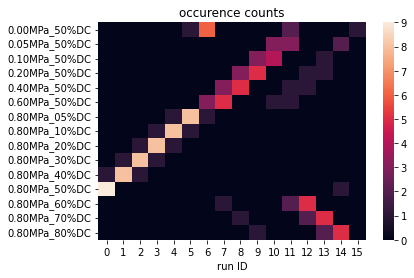

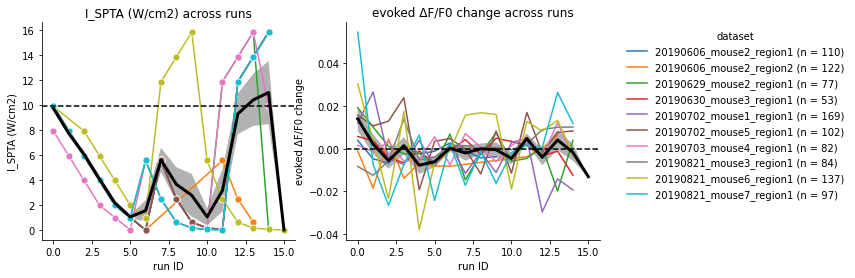

In [10]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
sns.heatmap(data=params_counts, ax=ax)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        ci=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='o' if ykey == Label.ISPTA else None,
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Fit response strength = f(ISPTA)

 10/03/2023 17:35:47: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 10/03/2023 17:35:47: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using sigmoid function: p0 = [1, 1, 1]
 10/03/2023 17:35:47: fitting results: popt = [8.92109228e+00 2.33937378e-02 4.07506954e-03], R2 = 0.19
 10/03/2023 17:35:47: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using shift_sqrt function: p0 = [1, 1]
 10/03/2023 17:35:47: fitting results: popt = [1.18706898e+01 1.39726632e-03], R2 = 0.03
 10/03/2023 17:35:47: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using parabolic function: p0 = [0, 1, 1]
 10/03/2023 17:35:47: fitting results: popt = [-8.63226483e+00  8.35897304e+00  2.14214146e-05], R2 = 0.12
 10/03/2023 17:35:47: best fit: evoked ΔF/F0 change = sigmoid(I_SPTA (W/cm2), 8.92, 0.02, 0.00) ---> R2 = 0.19


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


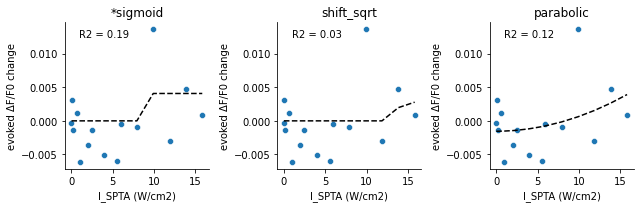

In [11]:
ykey_diff = get_change_key(Label.DFF)
# Compute weighted average of output metrics across datasets
lineavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUN, ykey=ykey_diff).rename(columns={'mean': ykey_diff})

# Compute fits between ISPTA and response strength, and plot results
from utils import shift_sqrt
fit_candidates = {
    sigmoid: [1, 1, 1],
    shift_sqrt: [1, 1],
    parabolic: [0, 1, 1],
}
figs[f'isptafits'], best_fitfunc = plot_ispta_fit(lineavg_stats, ykey_diff, fit_candidates)

# # Compute average ISPTA and response strength per run ID
# runidavg_stats = get_crossdataset_average(
#     trialagg_stats, Label.RUNID, ykey=ykey_diff).rename(columns={'mean': ykey_diff})
# runidavg_stats[Label.ISPTA] = get_crossdataset_average(
#     trialagg_stats, Label.RUNID, ykey=Label.ISPTA)['mean']
# # Restrict to first 15 runs to eliminate sparse run 16
# runidavg_stats = runidavg_stats.iloc[:-1, :]

# # Predict response strength over time bases on ISPTA fit
# runidavg_stats['fit'] = best_fitfunc(runidavg_stats[Label.ISPTA]).fillna(0.)

# # Plot evolution of ISPTA and response strength (data & fit) over runs
# figs['resp vs time - data vs. pred'], axes = plt.subplots(1, 2, figsize=(6, 3))
# for ax in axes:
#     sns.despine(ax=ax)
# sns.lineplot(
#     data=runidavg_stats, x=Label.RUNID, y=Label.ISPTA, ax=axes[0], marker='o', color='k')
# sns.lineplot(data=runidavg_stats, x=Label.RUNID, y=ykey_diff, ax=axes[1], marker='o', label='data')
# sns.lineplot(data=runidavg_stats, x=Label.RUNID, y='fit', ax=axes[1], marker='o', label='fit')
# axes[1].legend()
# figs['resp vs time - data vs. pred'].tight_layout()

### Inspect initial parameter dependency curves

 10/03/2023 17:35:47: sub-indexing data...
 10/03/2023 17:35:47: filtering data...
 10/03/2023 17:35:47: cross-checking filters...
 10/03/2023 17:35:47: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 10/03/2023 17:35:47: sub-indexing data...
 10/03/2023 17:35:47: filtering data...
 10/03/2023 17:35:47: cross-checking filters...
 10/03/2023 17:35:47: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 10/03/2023 17:35:47: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 10/03/2023 17:35:47: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 10/03/2023 17:35:47: sub-indexing data...
 10/03/2023 17:35:47: filtering data...
 10/03/2023 17:35:47: cross-checking filters...
 10/03/2023 17:35:47: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. I_SPTA (W/cm2) ...


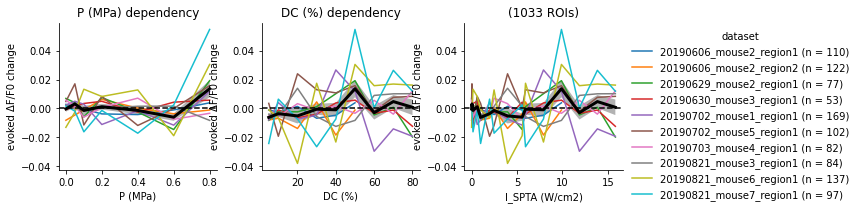

In [12]:
ykey_diff = get_change_key(Label.DFF)
figs[f'stimparamdeps initial'] = plot_stimparams_dependency(
    trialagg_stats.copy(),
    xkeys=xkeys_plt,
    ykey=ykey_diff, 
    hue=Label.DATASET,
    avgprop='whue', 
    ci=None,
)

## Curations & corrections

#### <span style="color:orange">Manual curation steps (deprecated)</span>

In [13]:
ykey_diff = get_change_key(Label.DFF)
n_manual_curations = 0
for criterion in [Label.STRONGRESP]:  #, Label.NORESP, Label.DROP5060DC, Label.DROP0406MPA]:
    exclude_list = get_exclude_list(exclude_table, criterion)
    if len(exclude_list) > 0:
        figs[f'stimparamdeps exclude {criterion}'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue', 
            ci=None,
            outliers=exclude_list
        )
        for ax in figs[f'stimparamdeps exclude {criterion}'].axes:
            ax.set_title(None)
        figs[f'stimparamdeps exclude {criterion}'].suptitle(f'{criterion} exclusion')
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
            trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=exclude_list)
        n_manual_curations += 1

if n_manual_curations > 0:
    # Re-plot parameter dependency curves
    figs[f'stimparamdeps post manual curate'] = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        ci=None,
    )

### Identify and exclude datasets with no parameter dependency

In [14]:
%%skip $ispv

# Compute population-average stats
popagg_stats = get_popavg_data(ext_stats)

# Assess response parameter dependency per dataset with ANOVA
logger.info('assessing parameter dependence per dataset with ANOVA...')
anovares = (
    popagg_stats[ykey_diff]
    .groupby(Label.DATASET)
    .agg(lambda s: compute_1way_anova(s.reset_index(), Label.RUN, ykey_diff))
    .rename('pval')
    .to_frame()
)
anovares['sig'] = anovares['pval'] < PTHR_DETECTION
nonpdeps_datasets = anovares[~anovares['sig']].index.values.tolist()
logger.info(f'datasets with no parameter dependency:\n{pprint.pformat(nonpdeps_datasets)}')

# Create figure backbone
figs['pdep anova analysis'], axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    sns.despine(ax=ax)

# Plot p-value distributions
sns.histplot(
    ax=axes[0],
    data=anovares,
    x='pval',
    binwidth=.05,
    hue='sig',
    palette={True: 'g', False: 'r'}
)
axes[0].set_xlim(0, 1)

# Plot parameter dependencies per dataset, along with ANOVA result color code
sns.lineplot(
    ax=axes[1],
    data=popagg_stats,
    x=Label.RUN,
    y=ykey_diff,
    hue=Label.DATASET,
    palette=get_binary_palette(anovares, nonpdeps_datasets),
    ci=None,
    legend=False
)
axes[1].axhline(0, ls='--', c='k')

# Exclude datasets with no parameter dependency, and re-plot param dependency curves
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, 
    to_exclude=nonpdeps_datasets
)
figs[f'stimparamdeps post anova exclude'] = plot_stimparams_dependency(
    trialagg_stats.copy(),
    xkeys=xkeys_plt,
    ykey=ykey_diff, 
    hue=Label.DATASET,
    avgprop='whue', 
    ci=None,
)

### Inspect response stationarity throughout trial sequences

#### <span style="color:orange">Approach 1 (deprecated): exclude runs with non-stationary response, for each dataset</span>

In [15]:
%%skip True

# Determine output metrics
ykey_diff = get_change_key(Label.DFF)
stationarity_gby = Label.RUNID

# Compute population-average stats for each trial 
popagg_stats = get_popavg_data(ext_stats)

# Apply linear regression response strength = f(trial) for each trial sequence
# to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by {stationarity_gby} & dataset, with linear regression analysis')
linreg_stats = (popagg_stats
    .groupby([Label.DATASET, stationarity_gby])
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)
nonstat_seqs_idx = linreg_stats[linreg_stats['sig'] != 0].index
if len(nonstat_seqs_idx) > 0:
    logger.info(f'found {len(nonstat_seqs_idx)}/{len(linreg_stats)} non-stationary sequences:\n{nonstat_seqs_idx.to_frame(index=False)}')

# Expand and add that information to population-agg stats
logger.info('adding regression stats to popagg stats')
free_expand_and_add(linreg_stats, popagg_stats, prefix='reg_')

# Plot evolution of response strength along trial sequence, by run ID
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats, 
    col=stationarity_gby,
    units=Label.DATASET,
    estimator=None,
    hue='reg_sig',
    palette=Palette.TERNARY,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')

# Add weighted-average profiles on top
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata['mean'], c='k', lw=2)
figs[f'{ykey_diff} along trial seq'] = fg.figure

# If non-stationary sequences are detected
if len(nonstat_seqs_idx) > 0:
    # Exclude these non-stationary sequences
    logger.info('adding regression stats to trialagg stats')
    trialagg_stats2 = trialagg_stats.copy()
    free_expand_and_add(linreg_stats, trialagg_stats2, prefix='reg_')
    logger.info(f'excluding non-stationary sequences from data...') 
    trialagg_stats2 = trialagg_stats2[trialagg_stats2['reg_sig'] == 0]

    # Re-plot parameter dependency curves
    figs[f'stimparamdeps post local stationary exclude'] = plot_stimparams_dependency(
        trialagg_stats2.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        ci=None,
    )

#### Approach 2 (selected approach): Correct runs with non-stationarity response, in lumped data

 10/03/2023 17:35:48: computing population average data across (dataset, run, trial)...
 10/03/2023 17:35:48: plotting evoked ΔF/F0 change along trial sequences...
 10/03/2023 17:35:52: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs x 16 trials) "evoked ΔF/F0 change" series across run ID & trial...
 10/03/2023 17:35:52: adding regression estimates...
 10/03/2023 17:35:55: assessing evoked ΔF/F0 change stationarity, by run ID, with linear regression analysis
 10/03/2023 17:35:55: no significant evoked ΔF/F0 change non-stationarity identified


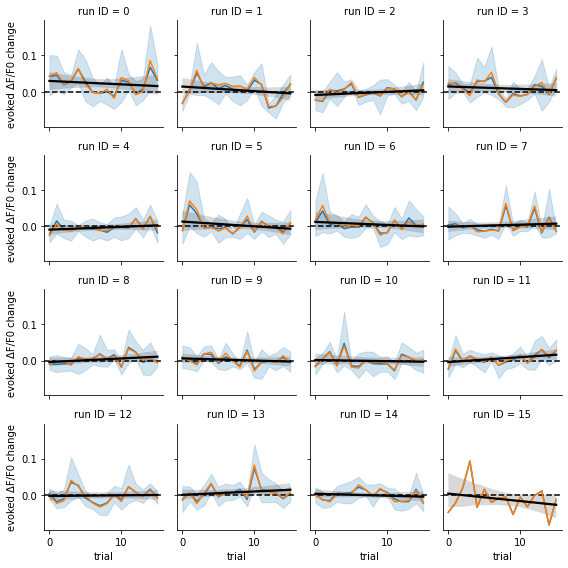

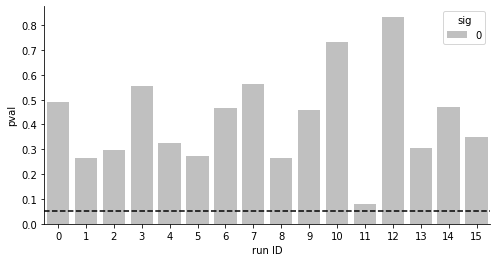

In [16]:
from constants import PTHR_STATIONARITY

# Determine output metrics
ykey_diff = get_change_key(Label.DFF)
stationarity_gby = Label.RUNID

# Compute population-average stats for each trial 
popagg_stats = get_popavg_data(ext_stats)

# Plot response strength over trial sequence, by run ID, with superimposed linear regression estimate
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats,
    col=stationarity_gby,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata['mean'], c='C1')
logger.info('adding regression estimates...')
fg.map_dataframe(
    sns.regplot, 
    scatter=False, 
    color='k', 
    x=Label.TRIAL, 
    y=ykey_diff
)
figs[f'{ykey_diff} stationarity along trial seq'] = fg.figure

# Perform detailed linear regression on lumped data, by run ID, to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by run ID, with linear regression analysis')
cross_dataset_linreg_stats = (popagg_stats
    .groupby(stationarity_gby)
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)

# Plot stationarity p-value for each run ID
figs[f'{ykey_diff} stationarity p-value by run'], ax = plt.subplots(figsize=(8, 4))
sns.despine(ax=ax)
sns.barplot(
    data=cross_dataset_linreg_stats.reset_index(),
    x=stationarity_gby,
    y='pval',
    hue='sig',
    palette=Palette.TERNARY,
    dodge=False,
)
ax.axhline(PTHR_STATIONARITY, ls='--', c='k')

# Identify and mark runs with non-stationarity in response strength
non_stationary_runs = cross_dataset_linreg_stats[cross_dataset_linreg_stats['sig'] != 0].index.values
has_non_stationary_runs = len(non_stationary_runs) > 0
if has_non_stationary_runs > 0:
    logger.warning(f'identified {ykey_diff} non-stationarity in run IDs {non_stationary_runs}')
    for k in non_stationary_runs:
        fg.axes_dict[k].set_title(f'{fg.axes_dict[k].get_title()} *', fontsize=10)
    nonzero_non_stationary_runs = non_stationary_runs[non_stationary_runs != 0]
    if len(nonzero_non_stationary_runs) > 0:
        logger.error(
            f'identified {ykey_diff} non-stationarity in run IDs other than 0: {nonzero_non_stationary_runs}')
else:
    logger.info(f'no significant {ykey_diff} non-stationarity identified')

# If response in initial run ID is non-stationary
if 0 in non_stationary_runs and do_nonstat_correct:
    
    # Extract detailed stats for that run ID 
    runid = 0
    logger.info(f'extracting detailed stats for run id {runid}...')
    detailed_stats_runid = ext_stats[ext_stats[Label.RUNID] == runid]

    # Extract last trial index for each ROI
    logger.info('extracting last trial index for each ROI...')
    last_trial_idx = (detailed_stats_runid.iloc[:, 0]
        .groupby([Label.DATASET, Label.ROI, Label.RUN])
        .agg(lambda s: s.index[-1][-1])
    )

    # Perform independent linear regression for each ROI, over trial sequence
    logger.info(f'performing {ykey_diff} linear regression independently on each ROI...')
    linreg_stats_per_roi = (detailed_stats_runid[ykey_diff]
        .groupby([Label.DATASET, Label.ROI, Label.RUN])
        .apply(apply_linregress)
        .unstack()
    )

    # Compute project response at last trial from linear regression results
    logger.info(f'projecting {ykey_diff} values from linear regression results...')
    ydiff_proj = linreg_stats_per_roi['slope'] * last_trial_idx + linreg_stats_per_roi['intercept']

    # Compute ratios between trial-aggregated and projected responses
    logger.info(f'computing ratios between trialagg {ykey_diff} values and their lin-reg projected values...')
    ratios = ydiff_proj / trialagg_stats.loc[ydiff_proj.index, ykey_diff]

    # Replace trial-aggregated response values by projected responses values 
    logger.info(f'replacing trialagg {ykey_diff} values by their lin-reg projected values...')
    trialagg_stats.loc[ydiff_proj.index, ykey_diff] = ydiff_proj

    # Use computed ratios to rescale z-scores as well
    zkey_diff = get_change_key(Label.ZSCORE)
    logger.info(f're-scaling trialagg {zkey_diff} values according to {ykey_diff} ratios...')
    trialagg_stats.loc[ydiff_proj.index, zkey_diff] *= ratios
    
    # Re-assess responses
    zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
    trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
        trialagg_stats[get_change_key(Label.ZSCORE)], zthr, directional=directional)

    # Re-classify responders
    roistats = classify_ROIs(trialagg_stats)
    for k in roistats:
        trialagg_stats[k] = roistats[k]

    # Re-plot parameter dependency curves
    figs[f'stimparamdeps post global stationary correct'] = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        ci=None,
    )
    
    do_nonstat_correct = False

## Results visualization

### Plot evoked change distribution for control condition (P = 0)

 10/03/2023 17:35:55: response type proportions at P = 0:
weak        94.282946
positive     5.717054
Name: response type, dtype: float64


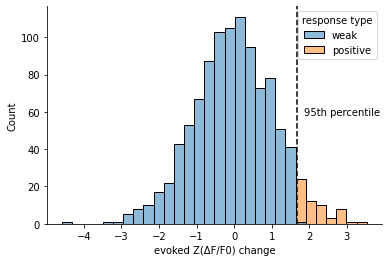

In [17]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot parameter dependency curves

 10/03/2023 17:35:56: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 10/03/2023 17:35:56: plotting ΔF/F0 stimulation parameters dependencies...
 10/03/2023 17:35:56: sub-indexing data...
 10/03/2023 17:35:56: filtering data...
 10/03/2023 17:35:56: cross-checking filters...
 10/03/2023 17:35:56: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 10/03/2023 17:35:56: sub-indexing data...
 10/03/2023 17:35:56: filtering data...
 10/03/2023 17:35:56: cross-checking filters...
 10/03/2023 17:35:56: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 10/03/2023 17:35:56: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 10/03/2023 17:35:56: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 10/03/2023 17:35:56: sub-indexing data...
 10/03/2023 17:35:56: filtering data...
 10/03/2023 17:35:56: cross-checking filters...
 10/03/2023 17:35:56: grouping by dataset, averaging and plotti

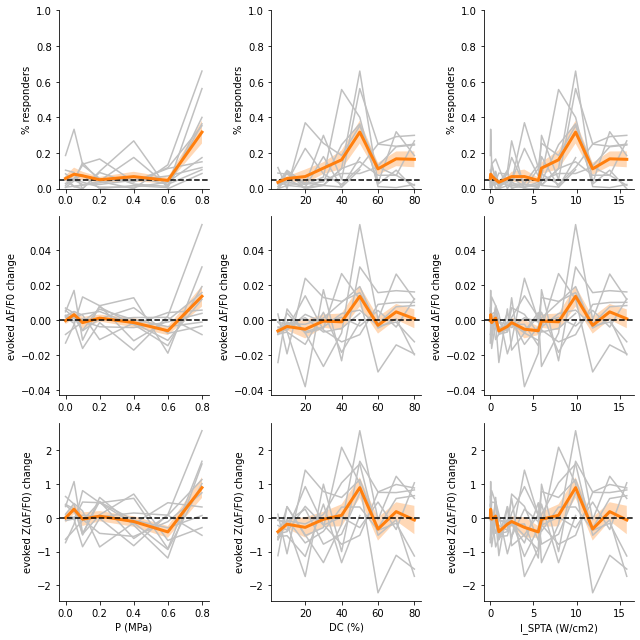

In [18]:
figs['stimparamdeps post curation'] = plot_all_deps(
    trialagg_stats, 
    xkeys_plt, 
    ykeys_plt,
    palette='uniform',
    avg_color='line',
)

### Fit response strength = f(ISPTA)

 10/03/2023 17:35:57: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 10/03/2023 17:35:57: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using sigmoid function: p0 = [1, 1, 1]
 10/03/2023 17:35:57: fitting results: popt = [8.92109228e+00 2.33937378e-02 4.07506954e-03], R2 = 0.19
 10/03/2023 17:35:57: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using shift_sqrt function: p0 = [1, 1]
 10/03/2023 17:35:57: fitting results: popt = [1.18706898e+01 1.39726632e-03], R2 = 0.03
 10/03/2023 17:35:57: fitting evoked ΔF/F0 change to I_SPTA (W/cm2) using parabolic function: p0 = [0, 1, 1]
 10/03/2023 17:35:57: fitting results: popt = [-8.63226483e+00  8.35897304e+00  2.14214146e-05], R2 = 0.12
 10/03/2023 17:35:57: best fit: evoked ΔF/F0 change = sigmoid(I_SPTA (W/cm2), 8.92, 0.02, 0.00) ---> R2 = 0.19


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


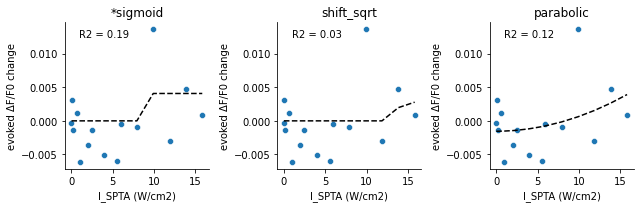

In [19]:
ykey_diff = get_change_key(Label.DFF)
# Compute weighted average of output metrics across datasets
lineavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUN, ykey=ykey_diff).rename(columns={'mean': ykey_diff})

# Fit various functions to ISPTA - response strength relationship, and plot results
figs['isptafit post curation'], _ = plot_ispta_fit(lineavg_stats, ykey_diff, fit_candidates)

### ROI breakdown per dataset

 10/03/2023 17:35:57: computing fraction of response occurence per ROI over 10 "strong ISPTA" conditions...
 10/03/2023 17:35:57: identified 3.4% of responders with 0.5 as threshold proportion of responding conditions
 10/03/2023 17:35:57: plotting cell maps...


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


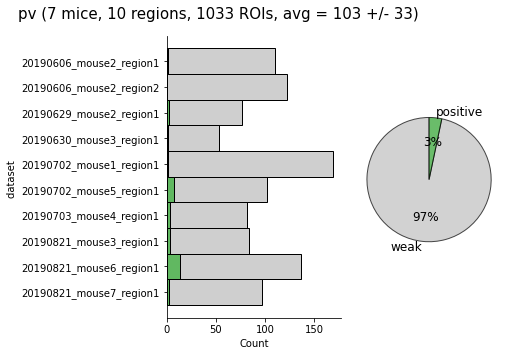

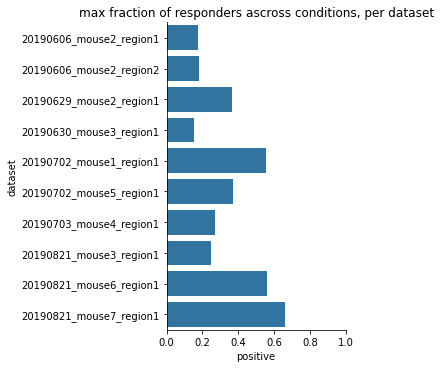

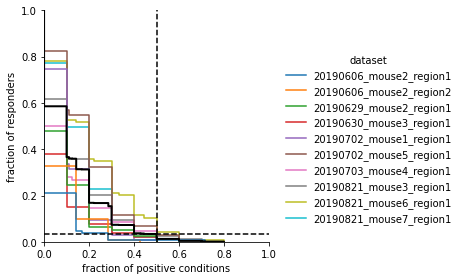

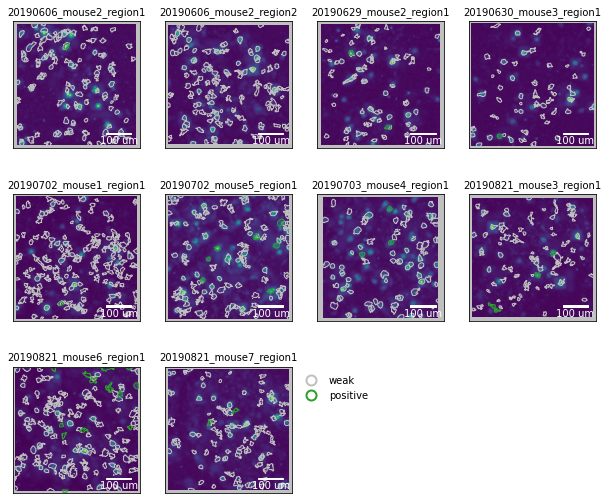

In [20]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_cell_maps(ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour')

### Inspect dynamics of population-averaged activity

In [21]:
%%skip ~$ispv

# Define output metrics
ykey = Label.DFF

# Define frequency band for neural oscillations of interest
fband_osc = [.09, .5]  # Hz

# Extract frame rate
fps = get_singleton(trialagg_stats, Label.FPS)

# Define plotting options
merge_metrics = True
fmax = .5  # upper frequency limit for specturm graphs

# Define BW filter function and apply it to population-averaged data, per dataset and run
filterfunc = get_butter_filter_func(fps, fband_osc, btype='bandstop')
popagg_timeseries_filtered = (popagg_timeseries[ykey]
    .groupby([Label.DATASET, Label.RUN])
    .apply(filterfunc)
    .to_frame()
)

# Plot timecourses and frequency spectra across runs, for original and filtered data
tmpdata = {
    'original': popagg_timeseries,
    'filtered': popagg_timeseries_filtered
}
for k, v in tmpdata.items():
    if merge_metrics:
        groups = v.groupby(Label.DATASET)
        figs[f'popagg {ykey} metrics {k}'], axes = plt.subplots(
            groups.ngroups, 2, figsize=(10, 4.5 * groups.ngroups), 
            gridspec_kw=dict(width_ratios=(1, .2)))
        for axrow, (dadaset_id, gdata) in zip(axes, groups):
            mydata = gdata.reset_index(level=Label.DATASET, drop=True)
            plot_popagg_timecourse(mydata, ykey, fps, ax=axrow[0], legend=False)
            plot_popagg_frequency_spectrum(mydata, ykey, fps, fmax=fmax, fband=fband_osc, ax=axrow[1])
            sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
            axrow[0].set_title(dadaset_id.replace('_', ' '))
        figs[f'popagg {ykey} metrics {k}'].subplots_adjust(hspace=0.3)
    else:
        figs[f'popagg {ykey} profiles {k}'] = plot_popagg_timecourse(
            v, ykey, fps, normalize_gby=Label.DATASET, title=mouseline)
        figs[f'popagg {ykey} frequency spectra {k}'] = plot_popagg_frequency_spectrum(
            v, ykey, fps, fmax=fmax, fband=fband_osc, 
            normalize_gby=Label.DATASET, title=mouseline)

### Examine variability of responses

In [22]:
%%skip True
# Get fraction of responders for each dataset, run & trial
ext_resp_props = get_responders_counts(
    ext_stats, Label.RUN, units=[Label.DATASET, Label.TRIAL], normalize=True)

# Plot distirbution of responder fraction across datasets & trial, per condition
sns.catplot(
    data=ext_resp_props.reset_index(Label.RUN),
    kind='box',
    y='positive',
    x=Label.RUN,
    height=4,
    aspect=2
)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# testdata = ext_resp_props['positive']
testdata = ext_stats[ykey_diff]
testgroupby = [Label.RUN, Label.DATASET]
pthr = PTHR_DETECTION

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'tests on {testdata.name} distributions')
sns.despine(fig=fig)
histkwargs = dict(
    x='pval',
    bins=np.linspace(0, 1, 21),
    stat='density',
    hue='H0'
)
# Test if distributions are normal
from scipy.stats import normaltest
isnormal = apply_test(
    testdata, testgroupby, normaltest, pthr=pthr)
axes[0].set_title('normal test (H0: normal)')
sns.histplot(
    ax=axes[0],
    data=isnormal,
    **histkwargs
)

# Test if distributions are multimodal
from diptest import diptest
ismultimodal = apply_test(
    testdata, testgroupby, diptest, pthr=pthr)
axes[1].set_title('dip test (H0: unimodal)')
sns.histplot(
    ax=axes[1],
    data=ismultimodal,
    **histkwargs
)

In [23]:
%%skip True
# For each dataset, compute 2-way ANOVA for trial vs. ROI
Ftable = ext_stats[ykey_diff].groupby(Label.DATASET).agg(compute_ROI_vs_trial_anova)
Ftable = pd.DataFrame(
    Ftable.tolist(),
    columns=[f'F({Label.TRIAL})', f'F({Label.ROI})'],
    index=Ftable.index
)
# Plot resulting F-scores on 2D scatter graph
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=Ftable,
    x=f'F({Label.TRIAL})',
    y=f'F({Label.ROI})',
    ax=ax
)
xymax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(0, xymax)
ax.set_ylim(0, xymax)
ax.axline((0, 0), (1, 1), ls='--', color='k')
ax.set_aspect(1.)

### Plot trial heatmap per condition for entire mouse line

In [24]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Plot response traces

In [25]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

## Exports

### Save responder-type-averaged stats to disk

In [26]:
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)
for errprop in ['intra', 'inter']:
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

 10/03/2023 17:36:00: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) dataframe across run...
 10/03/2023 17:36:00: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) dataframe across run...
 10/03/2023 17:36:00: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv_intra.csv...
 10/03/2023 17:36:00: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) dataframe across run...
 10/03/2023 17:36:00: computing ROI-weighted average of (10 datasets x 365 ROIs x 15 runs) dataframe across run...
 10/03/2023 17:36:00: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv_inter.csv...


### Save figures

In [27]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 10/03/2023 17:36:00: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.03.10/figs_main_pv_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


### Notify upon completion

In [28]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 10/03/2023 17:36:02: pv batch notebook completed in 0:00:23.027708 s
